# Bank Marketing Dataset
Predicting Term Deposit Suscriptions

## Importing libs

In [1]:
# Data
import pandas as pd

# Export
import pickle

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Modeling
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

## Loading data

In [2]:
df = pd.read_csv("../data/bank.csv")
df.sample(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
4036,30,management,single,tertiary,no,502,no,no,cellular,11,oct,463,3,95,6,success,yes
1826,32,management,married,tertiary,no,2465,yes,yes,cellular,7,may,923,1,-1,0,unknown,yes
5893,38,self-employed,married,secondary,no,746,no,no,unknown,20,jun,256,3,-1,0,unknown,no


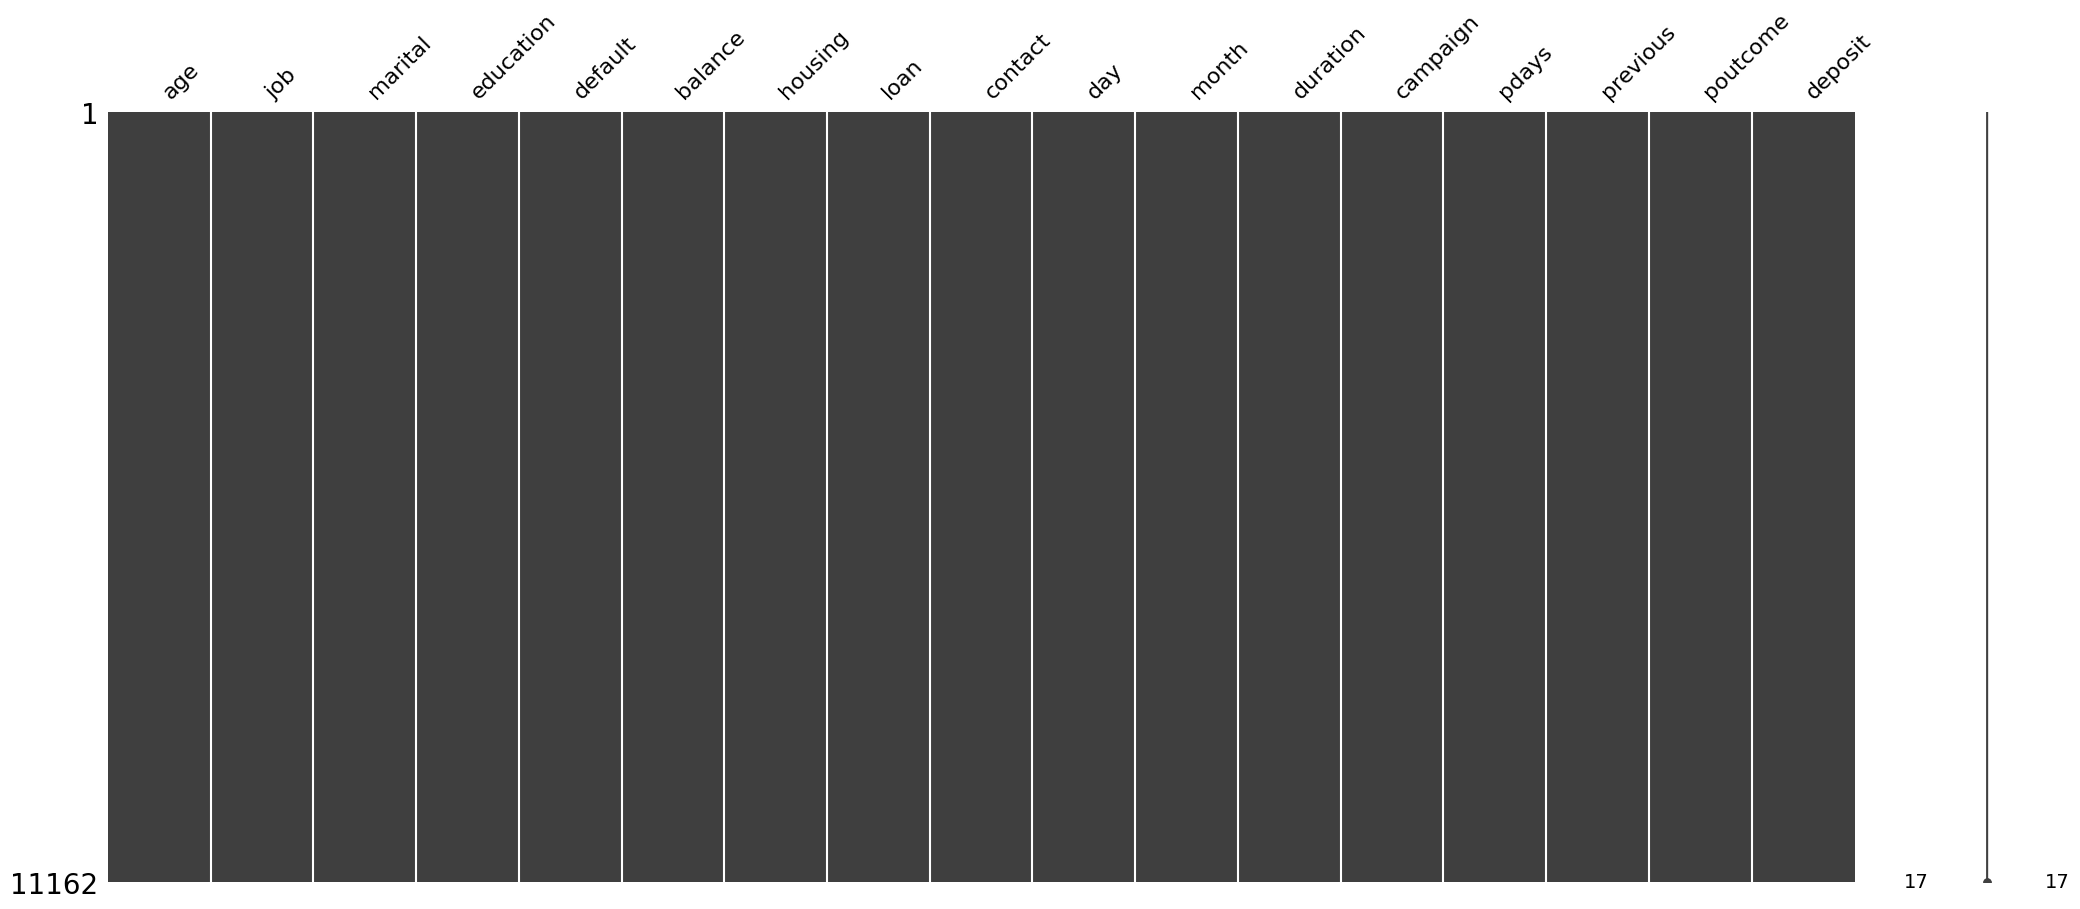

In [3]:
msno.matrix(df)
plt.show()

In [4]:
cat_cols = ["job", "marital", "education", "housing"]
num_cols = ["age", "balance", "duration", "campaign"]

In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


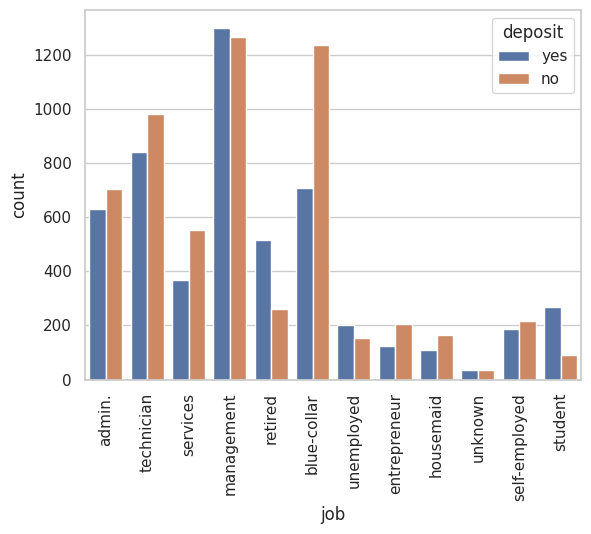

In [6]:
sns.set(style="whitegrid")
g = sns.countplot(data=df, x="job", hue="deposit")
g.set_xticklabels(g.get_xticklabels(), rotation=90);

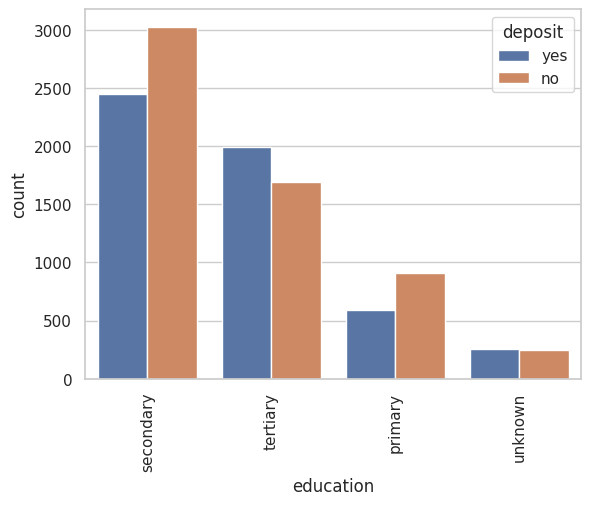

In [7]:
sns.set(style="whitegrid")
g = sns.countplot(data=df, x="education", hue="deposit")
g.set_xticklabels(g.get_xticklabels(), rotation=90);

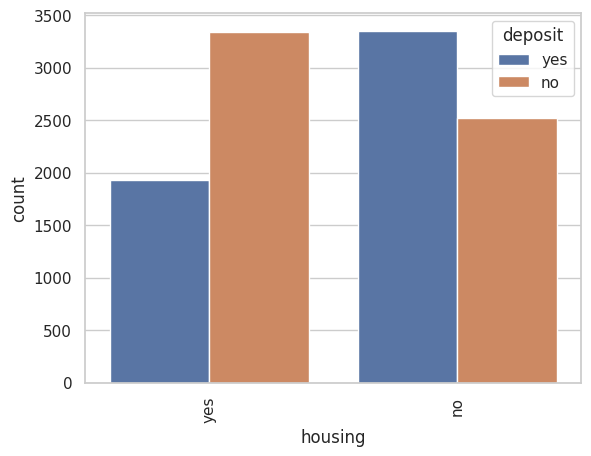

In [8]:
sns.set(style="whitegrid")
g = sns.countplot(data=df, x="housing", hue="deposit")
g.set_xticklabels(g.get_xticklabels(), rotation=90);

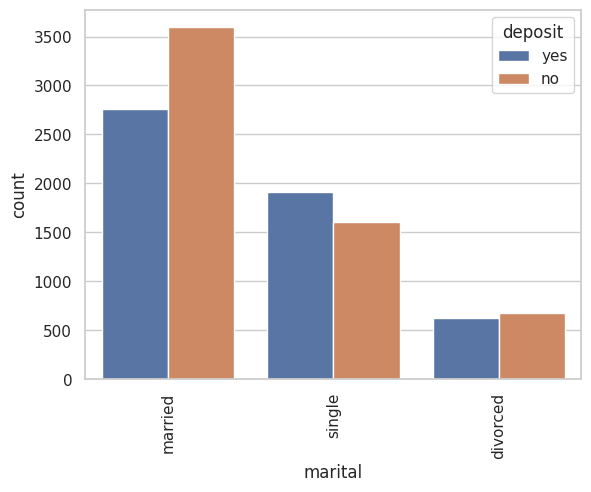

In [9]:
sns.set(style="whitegrid")
g = sns.countplot(data=df, x="marital", hue="deposit")
g.set_xticklabels(g.get_xticklabels(), rotation=90);

/home/antonio/Desktop/mlops/mlops/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


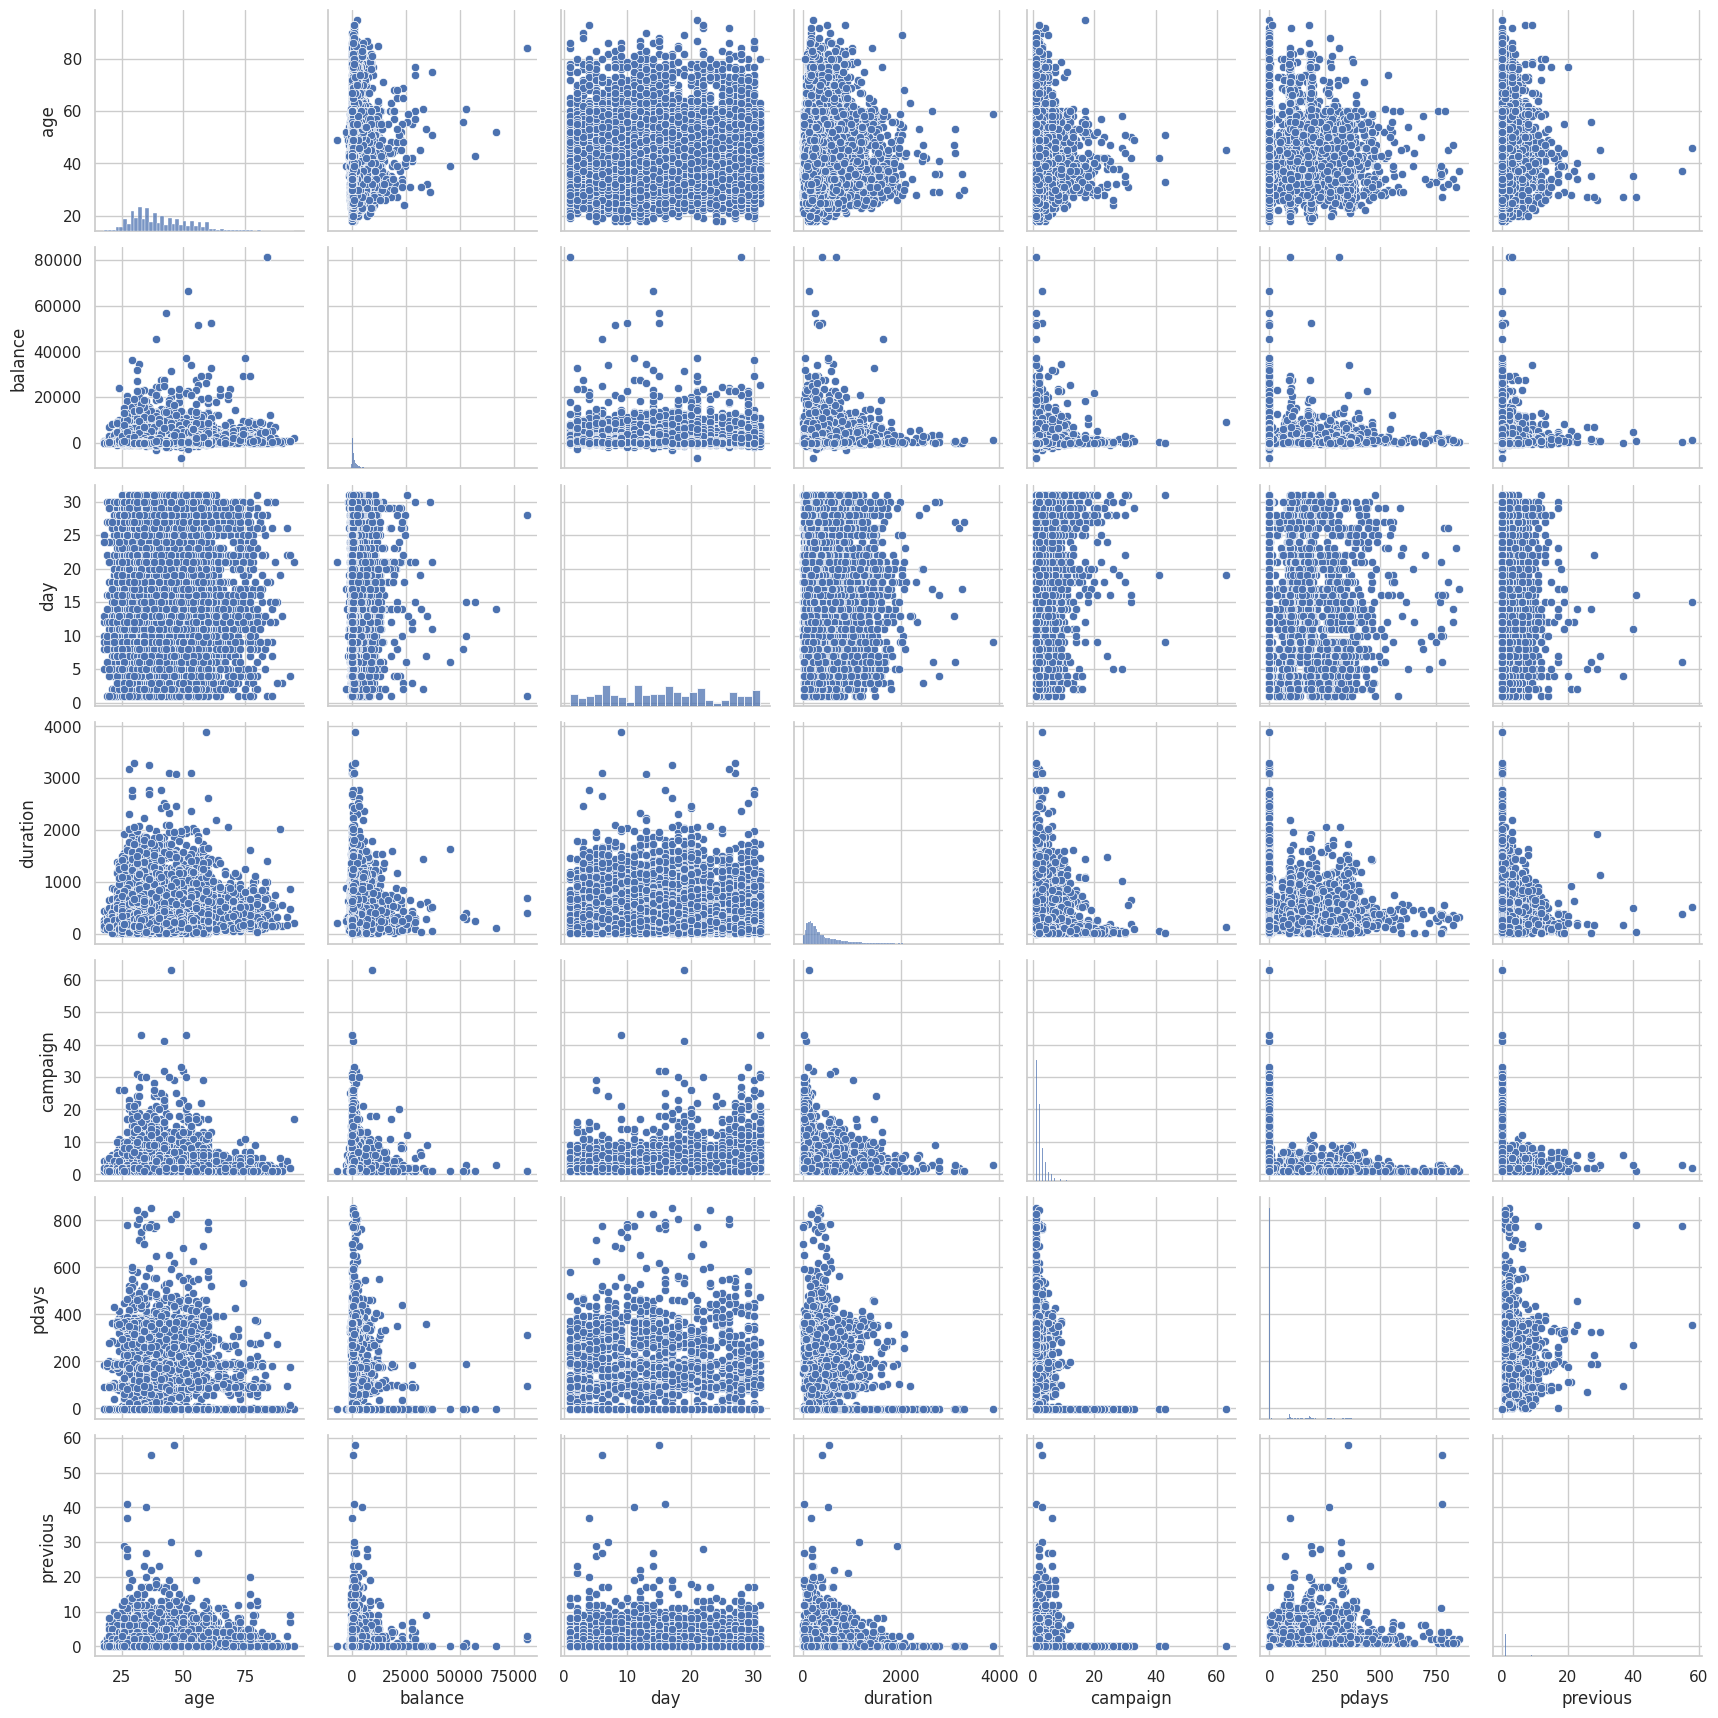

In [10]:
sns.pairplot(df)

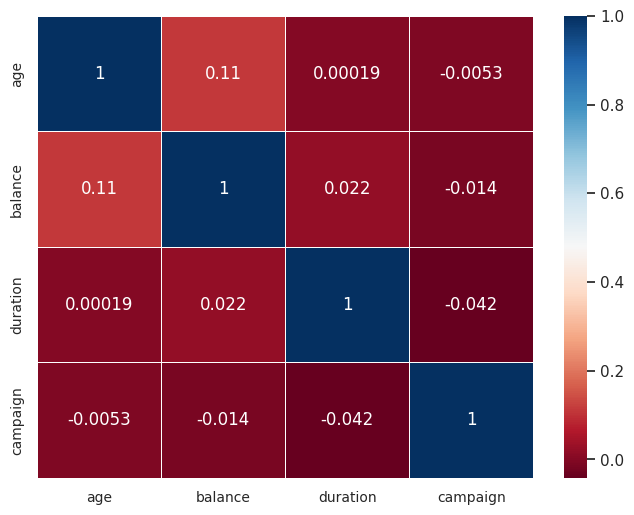

In [11]:
def correlation_matrix(df, cols):
     fig = plt.gcf()
     fig.set_size_inches(8, 6)
     plt.xticks(fontsize=10)
     plt.yticks(fontsize=10)
     fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={"size": 12}, linecolor="w", cmap="RdBu")
     plt.show(block=True)

correlation_matrix(df, num_cols)

## Model

split data into features and target 

In [12]:
X = df.drop("deposit", axis=1)
y = df["deposit"]

and make train test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1912)

In [14]:
X_test

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
7073,50,blue-collar,divorced,primary,no,388,no,no,cellular,5,feb,701,1,-1,0,unknown
9277,35,technician,single,secondary,no,-54,yes,no,unknown,30,may,70,2,-1,0,unknown
1288,25,admin.,single,tertiary,no,3730,yes,no,cellular,27,feb,353,1,-1,0,unknown
2081,32,technician,single,tertiary,no,2684,yes,no,cellular,18,may,542,2,-1,0,unknown
2652,50,admin.,married,tertiary,no,6574,no,no,cellular,8,sep,495,1,92,3,success
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8442,34,self-employed,married,secondary,no,-56,yes,no,unknown,19,may,248,3,-1,0,unknown
318,41,entrepreneur,married,secondary,no,707,no,no,unknown,18,jun,707,1,-1,0,unknown
10216,26,student,single,tertiary,no,641,yes,no,cellular,15,may,55,1,368,1,failure
6257,52,housemaid,married,primary,no,256,no,no,cellular,6,aug,137,1,-1,0,unknown


In [15]:
one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", drop="first"),
    cat_cols),
    remainder="passthrough")

X_train = one_hot_enc.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=one_hot_enc.get_feature_names_out())

X_train.head(2)

,onehotencoder__job_blue-collar,onehotencoder__job_entrepreneur,onehotencoder__job_housemaid,onehotencoder__job_management,onehotencoder__job_retired,onehotencoder__job_self-employed,onehotencoder__job_services,onehotencoder__job_student,onehotencoder__job_technician,onehotencoder__job_unemployed,...,remainder__balance,remainder__loan,remainder__contact,remainder__day,remainder__month,remainder__duration,remainder__campaign,remainder__pdays,remainder__previous,remainder__poutcome
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-410,yes,cellular,9,jul,189,1,-1,0,unknown
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,558,no,cellular,6,may,186,2,-1,0,unknown


In [16]:
X_test = pd.DataFrame(one_hot_enc.transform(X_test), columns=one_hot_enc.get_feature_names_out())
X_test.head(2)

,onehotencoder__job_blue-collar,onehotencoder__job_entrepreneur,onehotencoder__job_housemaid,onehotencoder__job_management,onehotencoder__job_retired,onehotencoder__job_self-employed,onehotencoder__job_services,onehotencoder__job_student,onehotencoder__job_technician,onehotencoder__job_unemployed,...,remainder__balance,remainder__loan,remainder__contact,remainder__day,remainder__month,remainder__duration,remainder__campaign,remainder__pdays,remainder__previous,remainder__poutcome
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,388,no,cellular,5,feb,701,1,-1,0,unknown
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-54,no,unknown,30,may,70,2,-1,0,unknown


In [18]:
X_test

,onehotencoder__job_blue-collar,onehotencoder__job_entrepreneur,onehotencoder__job_housemaid,onehotencoder__job_management,onehotencoder__job_retired,onehotencoder__job_self-employed,onehotencoder__job_services,onehotencoder__job_student,onehotencoder__job_technician,onehotencoder__job_unemployed,...,remainder__balance,remainder__loan,remainder__contact,remainder__day,remainder__month,remainder__duration,remainder__campaign,remainder__pdays,remainder__previous,remainder__poutcome
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,388,no,cellular,5,feb,701,1,-1,0,unknown
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-54,no,unknown,30,may,70,2,-1,0,unknown
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3730,no,cellular,27,feb,353,1,-1,0,unknown
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2684,no,cellular,18,may,542,2,-1,0,unknown
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6574,no,cellular,8,sep,495,1,92,3,success
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3344,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-56,no,unknown,19,may,248,3,-1,0,unknown
3345,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,707,no,unknown,18,jun,707,1,-1,0,unknown
3346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,641,no,cellular,15,may,55,1,368,1,failure
3347,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,256,no,cellular,6,aug,137,1,-1,0,unknown


In [17]:
model = LGBMClassifier()
model.fit(X_train, y_train)

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: onehotencoder__job_blue-collar: object, onehotencoder__job_entrepreneur: object, onehotencoder__job_housemaid: object, onehotencoder__job_management: object, onehotencoder__job_retired: object, onehotencoder__job_self-employed: object, onehotencoder__job_services: object, onehotencoder__job_student: object, onehotencoder__job_technician: object, onehotencoder__job_unemployed: object, onehotencoder__job_unknown: object, onehotencoder__marital_married: object, onehotencoder__marital_single: object, onehotencoder__education_secondary: object, onehotencoder__education_tertiary: object, onehotencoder__education_unknown: object, onehotencoder__housing_yes: object, remainder__age: object, remainder__default: object, remainder__balance: object, remainder__loan: object, remainder__contact: object, remainder__day: object, remainder__month: object, remainder__duration: object, remainder__campaign: object, remainder__pdays: object, remainder__previous: object, remainder__poutcome: object

## Evaluation

In [ ]:
y_pred = model.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="g");

print(f"Specificity: {specificity}")
print("Confusion Matrix:")

In [ ]:
print(classification_report(y_test, y_pred))

## Save model

In [ ]:
# Specify the file path where you want to save the pickle file
file_path = "model.pkl"

# Save the model as a pickle file
with open(file_path, "wb") as f:
    pickle.dump(model, f)

file_path = "ohe.pkl"

# Save the OneHotEncoder as a pickle file
with open(file_path, "wb") as f:
    pickle.dump(one_hot_enc, f)

# References

- https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset
- https://www.kaggle.com/code/enesztrk/bank-credit-analysis-classification

In [19]:
X_train

NameError: name 'X_train' is not defined